# ATL03 - Raw Photon data 

## data downloading
This data is downloaded for a section of the florida everglades.
This is an API endpoint that can be used to reproduce the dataset. 

some variables to include:
- dem_h - height relative to best DEM

Note:The JSON should probably be changed to netcdf

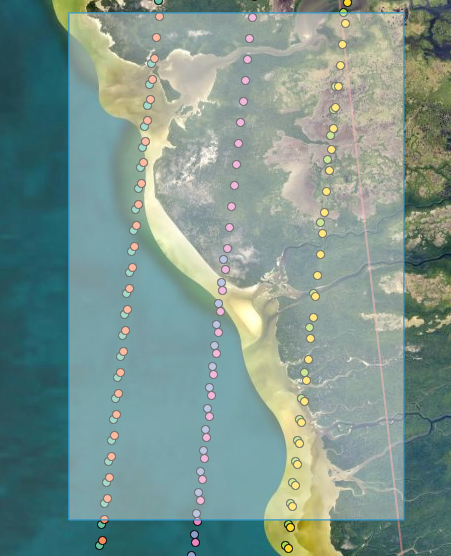


In [ ]:
api_endpoint = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2021-12-12&minx=-81.23891365678568&miny=25.39587929292906&maxx=-81.12390053422709&maxy=25.56994392915953&trackId=1231&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'

I predownloaded all the data for this site

## reading the data from the NetCDF

In [2]:
from netCDF4 import MFDataset,Dataset
import xarray as xr

First we can check to see the structure of the nc dataset

In [3]:
atl03_testfile = '../data/ATL03-test/232851345/processed_ATL03_20210831183341_10561201_005_01.nc'
ncds = Dataset(atl03_testfile)
print(ncds.groups.keys())
ncds.dimensions['ds_surf_type']

dict_keys(['METADATA', 'ancillary_data', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r'])


<class 'netCDF4._netCDF4.Dimension'>: name = 'ds_surf_type', size = 5

In [4]:
ncds.groups['gt1l'].groups['heights'].variables['h_ph']

<class 'netCDF4._netCDF4.Variable'>
float32 h_ph(delta_time)
    long_name: Photon WGS84 Height
    standard_name: height
    units: meters
    source: ATL03g ATBD, Section 3.4
    contentType: physicalMeasurement
    description: Height of each received photon, relative to the WGS-84 ellipsoid including the geophysical corrections noted in Section 6. Please note that neither the geoid, ocean tide nor the dynamic atmosphere (DAC) corrections are applied to the ellipsoidal heights.
    coordinates: delta_time lat_ph lon_ph
path = /gt1l/heights
unlimited dimensions: 
current shape = (43356,)
filling off

In [5]:
# note: get netcdf3 next time
# MFDataset('../data/ATL03-test/*/*.nc',aggdim='ds_surf_type')

## reading data with xarray

In [7]:
ds = xr.open_dataset(atl03_testfile,group='gt1l/heights',decode_coords="all")

In [8]:
ds.h_ph.to_numpy().shape

(43356,)

In [9]:
ds = xr.open_dataset(atl03_testfile,group='gt1l/heights')

ds.where(ds.ds_surf_type==2)

<xarray.Dataset>
Dimensions:         (delta_time: 43356, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 2021-08-31T18:40:17.750242160...
    lat_ph          (delta_time) float64 ...
    lon_ph          (delta_time) float64 ...
Dimensions without coordinates: ds_surf_type
Data variables:
    h_ph            (delta_time, ds_surf_type) float32 nan nan ... nan nan
    signal_conf_ph  (delta_time, ds_surf_type) float64 nan nan -1.0 ... nan nan
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

In [10]:
ds.assign_coords({'landsurface':ds.ds_surf_type})

<xarray.Dataset>
Dimensions:         (delta_time: 43356, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 2021-08-31T18:40:17.750242160...
    lat_ph          (delta_time) float64 ...
    lon_ph          (delta_time) float64 ...
    landsurface     (ds_surf_type) int64 0 1 2 3 4
Dimensions without coordinates: ds_surf_type
Data variables:
    h_ph            (delta_time) float32 ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

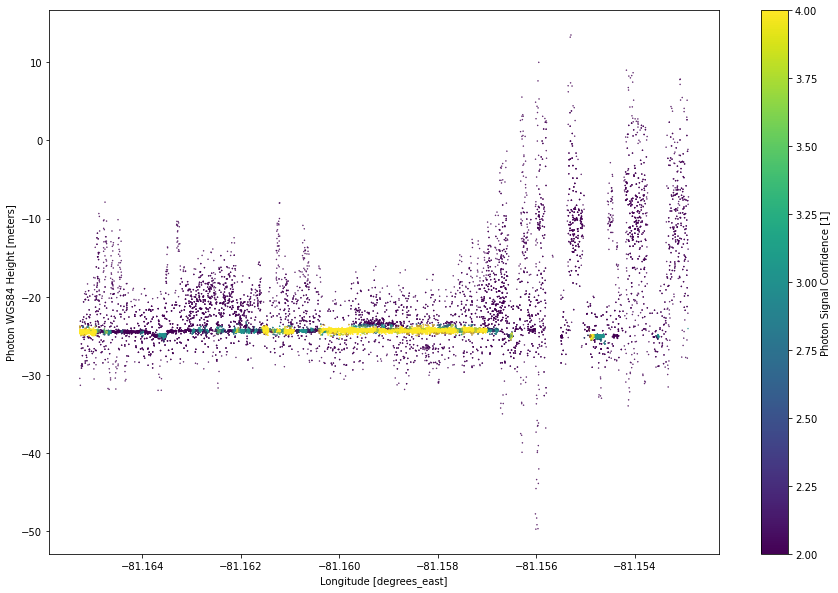

In [11]:
ds.where(ds.signal_conf_ph>1).plot.scatter(x='lon_ph',y='h_ph',hue='signal_conf_ph',s=.2,size=10)

In [15]:
pointdf = ds.to_dataframe()
# get the data points there there is a high confidence of the predicted surface
highconf = pointdf[pointdf.signal_conf_ph==4]

In [16]:
# learning an amazing new trick
pointdf.loc[pointdf.signal_conf_ph > 0].reset_index().query('ds_surf_type == [0,1,4]')

,delta_time,ds_surf_type,h_ph,lat_ph,lon_ph,signal_conf_ph
0,2021-08-31 18:40:17.750242160,1,-7.224942,25.457631,-81.152909,2
1,2021-08-31 18:40:17.751142176,0,-15.464334,25.457689,-81.152916,1
2,2021-08-31 18:40:17.751142176,1,-15.464334,25.457689,-81.152916,2
3,2021-08-31 18:40:17.751142176,1,-8.189652,25.457689,-81.152915,2
4,2021-08-31 18:40:17.751242176,0,-13.918337,25.457695,-81.152916,1
...,...,...,...,...,...,...
56809,2021-08-31 18:40:19.536842256,1,-24.238974,25.571842,-81.165271,4
56810,2021-08-31 18:40:19.536842256,4,-24.238974,25.571842,-81.165271,4
56811,2021-08-31 18:40:19.536942256,0,-30.464495,25.571848,-81.165272,2
56812,2021-08-31 18:40:19.536942256,1,-30.464495,25.571848,-81.165272,1


In [17]:
pointdf.query('ds_surf_type == [0,1,4]').query('signal_conf_ph > 0')

h_ph     lat_ph     lon_ph  \
delta_time                    ds_surf_type                                    
2021-08-31 18:40:17.750242160 1             -7.224942  25.457631 -81.152909   
2021-08-31 18:40:17.751142176 0            -15.464334  25.457689 -81.152916   
                              1            -15.464334  25.457689 -81.152916   
                              1             -8.189652  25.457689 -81.152915   
2021-08-31 18:40:17.751242176 0            -13.918337  25.457695 -81.152916   
...                                               ...        ...        ...   
2021-08-31 18:40:19.536842256 1            -24.238974  25.571842 -81.165271   
                              4            -24.238974  25.571842 -81.165271   
2021-08-31 18:40:19.536942256 0            -30.464495  25.571848 -81.165272   
                              1            -30.464495  25.571848 -81.165272   
                              4            -30.464495  25.571848 -81.165272   

                                            signal_conf_ph  
delta_time                    ds_surf_type                  
2021-08-31 18:40:17.750242160 1                          2  
2021-08-31 18:40:17.751142176 0                          1  
                              1                          2  
                              1                          2  
2021-08-31 18:40:17.751242176 0                          1  
...                                                    ...  
2021-08-31 18:40:19.536842256 1                          4  
                              4                          4  
2021-08-31 18:40:19.536942256 0                          2  
                              1                          1  
                              4                          1  

[56814 rows x 4 columns]

In [18]:
pts = pointdf.loc[pointdf.signal_conf_ph > 0].reset_index().query('ds_surf_type == [0,1,4]')
pts

,delta_time,ds_surf_type,h_ph,lat_ph,lon_ph,signal_conf_ph
0,2021-08-31 18:40:17.750242160,1,-7.224942,25.457631,-81.152909,2
1,2021-08-31 18:40:17.751142176,0,-15.464334,25.457689,-81.152916,1
2,2021-08-31 18:40:17.751142176,1,-15.464334,25.457689,-81.152916,2
3,2021-08-31 18:40:17.751142176,1,-8.189652,25.457689,-81.152915,2
4,2021-08-31 18:40:17.751242176,0,-13.918337,25.457695,-81.152916,1
...,...,...,...,...,...,...
56809,2021-08-31 18:40:19.536842256,1,-24.238974,25.571842,-81.165271,4
56810,2021-08-31 18:40:19.536842256,4,-24.238974,25.571842,-81.165271,4
56811,2021-08-31 18:40:19.536942256,0,-30.464495,25.571848,-81.165272,2
56812,2021-08-31 18:40:19.536942256,1,-30.464495,25.571848,-81.165272,1


<AxesSubplot:xlabel='lat_ph', ylabel='h_ph'>

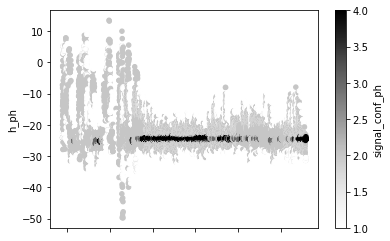

In [19]:
pts.plot.scatter(x='lat_ph',y='h_ph',c='signal_conf_ph')

## trying with pdal

In [171]:
import pdal
import pandas as pd
import geopandas as gpd
import json
from enum import Enum
from shapely.geometry import LineString
import geemap
map_ = geemap.Map()

In [119]:
class Beams():
    gt1l = "gt1l"
    gt1r = "gt1r"
    gt2l = "gt2l"
    gt2r = "gt2r"
    gt3l = "gt3l"
    gt3r = "gt3r"


In [125]:
def write_pdal_pipeline(filename,beam):
    # since i used an enum i need to coerece the beam into a string
    beam = str(beam)
    pipestring = f"""
[{{
        "type": "readers.hdf",
        "filename": "{filename}",
        "dimensions":
        {{
            "X" : "{beam}/heights/lon_ph",
            "Y" : "{beam}/heights/lat_ph",
            "Z" : "{beam}/heights/h_ph",
            "tr_d":"{beam}/heights/dist_ph_along"
        }}
    }}
]
"""
    return pipestring

In [167]:
def load_beam_array(filename,beam):
    pipelinejson = write_pdal_pipeline(filename,beam)
    pipelineobject = pdal.Pipeline(pipelinejson)
    pipelineobject.execute()
    return pipelineobject.arrays[0]
    
def get_track_gdf(outarray):
    coords = [[output['X'].min(),output['Y'].min()],[output['X'].max(),output['Y'].max()]]
    print(coords)
    linegeom = LineString(coords)
    return gpd.GeoDataFrame({'geometry':[linegeom]},crs="EPSG:7912",geometry='geometry')

In [168]:
testfile = '../data/ATL03-test/224708575/processed_ATL03_20190307135537_10560201_005_01.nc'

In [169]:
gt1l = load_beam_array(testfile,Beams.gt1l)

<AxesSubplot:xlabel='tr_d', ylabel='Z'>

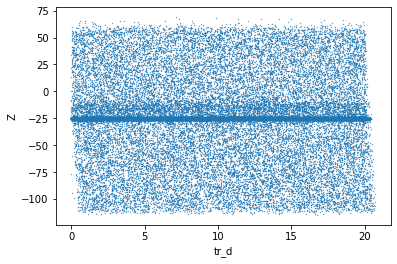

In [170]:
pd.DataFrame(gt1l).plot.scatter(x='tr_d',y='Z',s=0.1)

In [172]:
geodf = get_track_gdf(gt1l)

[[-81.11919777676194, 25.26811678576371], [-81.10350103795523, 25.41315099066048]]


In [175]:
beamlist = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']



In [173]:
map_.add_gdf(geodf)

In [174]:
map_

Map(center=[25.340633888212096, -81.11134940735857], controls=(WidgetControl(options=['position', 'transparent…